In [1079]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import triangle as tr
from numba import njit

Уравнение теплопроводности в 2D имеет вид:
\begin{equation}
\frac{\partial u(x,y,t)}{\partial t} = \alpha^2 \Delta u(x,y,t) + f(x,y,t)
\end{equation}

В вариационном виде:
\begin{equation}
\int_\Omega \left(\frac{\partial u(x,y,t)}{\partial t} - \alpha^2 \Delta u(x,y,t) - f(x,y,t)\right)vd\Omega = 0
\end{equation}

\begin{equation}
\int_{\Omega} \left(\frac{\partial u}{\partial t} v + \alpha^2 \nabla u \nabla v - fv\right)d\Omega - \alpha^2\int_{\partial \Omega}  v \frac{\partial u}{\partial \mathbf{n}}  d(\partial \Omega) = 0
\end{equation}

Зануляем так как считаем область изолированной.
\begin{equation}
\alpha^2\int_{\partial \Omega}  v \frac{\partial u}{\partial \mathbf{n}}  d(\partial \Omega) = 0
\end{equation}

\begin{equation}
\int_{\Omega} \left(\frac{\partial u}{\partial t} v + \alpha^2 \nabla u \nabla v - fv\right)d\Omega  = 0
\end{equation}

\begin{equation}
\int_{\Omega} \left(\frac{\partial u}{\partial t} v + \alpha^2  \left(\!\begin{array}{c}  
 \partial_x u  & \partial_y u
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x v \\  \partial_y v
 \end{array} \!\right)  - fv\right)d\Omega  = 0
\end{equation}

Пробные функции разобьем по узлам во времени.
\begin{equation}
u^h = \sum_{i}^N Q_i(t)\phi_i(x, y)
\end{equation}
Q - соответствует значению в i-том узле во время t
\begin{equation}
Q_i(t) = Q(x_i,y_i, t)
\end{equation}

\begin{equation}
\int_{\Omega} \left(\frac{\partial u}{\partial t} v + \alpha^2  \left(\!\begin{array}{c}  
 \partial_x u  & \partial_y u
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x v \\  \partial_y v
 \end{array} \!\right) \right) d\Omega   = \int_{\Omega}fvd\Omega  
\end{equation}

$$Au=f$$

$$(Au_n, v_n)=(f,v_n)$$


$$(Au_n, \sum_{j}^N Q_j(t)\phi_j(x, y))=(f,\sum_{j}^N Q_j(t)\phi_j(x, y))$$


$$\sum_{j}^N(Au_n,  Q_j(t)\phi_j(x, y))=\sum_{j}^N (f,Q_j(t)\phi_j(x, y))$$


$$\sum_{j}^NQ_j(t)(Au_n,  \phi_j(x, y))=\sum_{j}^NQ_j(t) (f,\phi_j(x, y))$$


$$\sum_{j}^NQ_j(t)(Au_n,  \phi_j(x, y))=\sum_{j}^NQ_j(t) (f,\phi_j(x, y))$$

$$(Au_n, \phi_j(x, y))=(f, \phi_j(x, y))$$
$$j=0,1,..,N$$

\begin{equation}
\int_{\Omega} \left(\left(\sum_{i}^N \frac{\partial }{\partial t}Q_i(t)\phi_i(x, y)\right) \phi_j(x, y) + \alpha^2  \left(\!\begin{array}{c}  
  \sum_{i}^N Q_i(t)\partial_x\phi_i(x, y)  &  \sum_{i}^N Q_i(t)\partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega   = \int_{\Omega}f\phi_j(x, y)d\Omega  
\end{equation}

\begin{equation}
\int_{\Omega} \left(\left(\sum_{i}^N \frac{\partial }{\partial t}Q_i(t)\phi_i(x, y)\right) \phi_j(x, y) + \alpha^2  \sum_{i}^N Q_i(t)\left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega   = \int_{\Omega}f\phi_j(x, y)d\Omega  
\end{equation}

\begin{equation}
\int_{\Omega} \left(\sum_{i}^N \frac{\partial }{\partial t}Q_i(t)\phi_i(x, y)\right) \phi_j(x, y)d\Omega + \int_{\Omega}\left( \alpha^2  \sum_{i}^N Q_i(t)\left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega   = \int_{\Omega}f\phi_j(x, y)d\Omega  
\end{equation}

\begin{equation}
\sum_{i}^N\frac{\partial }{\partial t}Q_i(t) \int_{\Omega} \phi_i(x, y) \phi_j(x, y)d\Omega + \alpha^2  \sum_{i}^NQ_i(t)\int_{\Omega}\left(  \left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega   = \int_{\Omega}f\phi_j(x, y)d\Omega  
\end{equation}

Переходя к векторной записи аналагичной выводу для одномерного случая, имеем:
\begin{equation}
K\partial_t Q + \alpha^2 M Q = F
\end{equation}

как и с одномерным случаем по времени используем метод Кранка-Николсона:
\begin{equation}
(K + \alpha^2 \frac{\Delta t}{2} M) Q^{n+1}  = \frac{\Delta t}{2}(F^n + F^{n+1}) + (K-\alpha^2 \frac{\Delta t}{2}M) Q^n
\end{equation}

Где:
\begin{equation}
K_{i,j} = \int_{\Omega} \phi_i(x,y) \phi_j(x,y)d\Omega
\end{equation}
\begin{equation}
M_{i,j} = \int_{\Omega}\left(  \left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega
\end{equation}
\begin{equation}
F =  \begin{pmatrix}
  \int_{\Omega} f\phi_0(x,y))d\Omega \\
  \int_{\Omega} f\phi_1(x,y))d\Omega \\
  \vdots  \\
  \int_{\Omega}f \phi_N(x,y))d\Omega 
 \end{pmatrix}
\end{equation}

Будем интерполировать неизвестную функцию u(x, y) на элементе линейной функцией, то есть
\begin{equation}
u^l(x,y) = \alpha_1 + \alpha_2x + \alpha_3 y
\end{equation}

Линейный треугольный элемент:
Интерполяция проводится так, чтобы значения точного решения и приближенного совпадали в узлах сетки, то есть
\begin{equation}
\begin{cases}
u_i = \alpha_1 + \alpha_2x_i + \alpha_3 y_i \\
u_j = \alpha_1 + \alpha_2x_j + \alpha_3 y_j \\
u_k = \alpha_1 + \alpha_2x_k + \alpha_3 y_k
\end{cases}
\end{equation}

\begin{equation}
u^l = \frac{1}{2A} (u_i(x_jy_k-x_ky_j+(y_j - y_k)x + (x_k-x_j)y) + u_j(x_ky_i - x_iy_k + (y_k-y_i)x + (x_i - x_k)y) + u_k(x_iy_j- x_jy_i+(y_i-y_j)x + (x_j-x_i)y)
\end{equation}

Площадь треугольника:
\begin{equation}
A = 
\frac{1}{2}\left|
\begin{matrix}
1 & x_i & y_i \\
1 & x_j & y_j \\
1 & x_k &  y_k
\end{matrix}
\right|
\end{equation}

\begin{equation}
u^l = N_iu_i + N_ju_j + N_ku_k
\end{equation}
\begin{equation}
N_e = \frac{1}{2A} (a_e+b_ex+c_ey)
\end{equation}

\begin{equation}
\begin{cases}
a_i = x_jy_k - x_ky_j \\
b_i = y_j - y_k\\
c_i = x_k - x_j
\end{cases}
\begin{cases}
a_j = x_ky_i - y_kx_i \\
b_j = y_k - y_i\\
c_j = x_i - x_k
\end{cases}
\begin{cases}
a_k = x_iy_j - x_jy_i \\
b_k = y_i - y_j\\
c_k = x_j - x_i
\end{cases}
\end{equation}

\begin{equation}
M_{i,j} = \int_{\Omega}\left(  \left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega
\end{equation}

\begin{equation}
N_e = \frac{1}{2A} (a_e+b_ex+c_ey)
M_{i,j} = \int_{\Omega}\left(  \left(\!\begin{array}{c}  
  \partial_x\phi_i(x, y)  &  \partial_y\phi_i(x, y)
 \end{array} \!\right) \left(\!\begin{array}{c}  
 \partial_x \phi_j(x, y) \\  \partial_y \phi_j(x, y)
 \end{array} \!\right) \right) d\Omega
\end{equation}

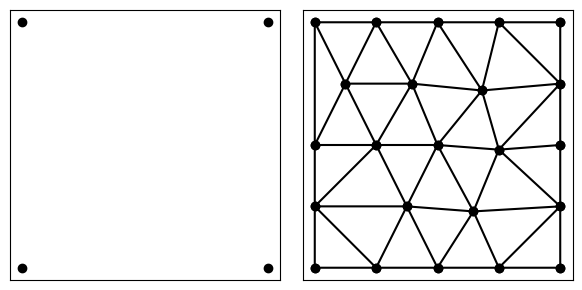

In [43]:
# Определение точек
vertices = np.array(((0, 0), (1, 0), (1, 1), (0, 1)))

# Создание словаря с данными для триангуляции
data = dict(vertices=vertices)

# Триангуляция
triangulation = tr.triangulate(data, 'qa0.05')

# Отображение триангуляции
tr.compare(plt, data, triangulation)
plt.show()


In [44]:

# Извлечение координат вершин
tri_vertices = triangulation['vertices']

# Извлечение индексов вершин для каждого треугольника
tri_triangles = triangulation['triangles']

# # Извлечение информации о соседних треугольниках
# neighbors = triangulation['neighbors']

# Вывод информации о треугольниках и их соседях
print("Информация о треугольниках и их соседях:")
for i, triangle in enumerate(tri_triangles):
    vertices_str = ", ".join([f"({tri_vertices[vertex][0]}, {tri_vertices[vertex][1]})" for vertex in triangle])
    # neighbor_indices = neighbors[i]
    # neighbors_str = ", ".join([str(neighbor) if neighbor != -1 else "None" for neighbor in neighbor_indices])
    print(f"Треугольник {i + 1}: вершины {vertices_str}")

Информация о треугольниках и их соседях:
Треугольник 1: вершины (0.6808712121212122, 0.7220643939393939), (1.0, 0.75), (0.75, 1.0)
Треугольник 2: вершины (0.0, 0.25), (0.25, 0.5), (0.0, 0.5)
Треугольник 3: вершины (0.25, 1.0), (0.0, 1.0), (0.125, 0.75)
Треугольник 4: вершины (0.125, 0.75), (0.0, 1.0), (0.0, 0.5)
Треугольник 5: вершины (0.5, 0.5), (0.6463632001157016, 0.2294316000578508), (0.75, 0.48106716821735473)
Треугольник 6: вершины (0.6463632001157016, 0.2294316000578508), (0.375, 0.25), (0.5, 0.0)
Треугольник 7: вершины (0.25, 0.5), (0.0, 0.25), (0.375, 0.25)
Треугольник 8: вершины (0.25, 0.5), (0.39583333333333337, 0.75), (0.125, 0.75)
Треугольник 9: вершины (0.25, 0.0), (0.0, 0.25), (0.0, 0.0)
Треугольник 10: вершины (0.39583333333333337, 0.75), (0.25, 0.5), (0.5, 0.5)
Треугольник 11: вершины (0.5, 1.0), (0.39583333333333337, 0.75), (0.6808712121212122, 0.7220643939393939)
Треугольник 12: вершины (0.0, 0.5), (0.25, 0.5), (0.125, 0.75)
Треугольник 13: вершины (0.5, 0.0), (0.375

In [1080]:
def phi(k, l, N):
    fild = np.zeros((N,N))
    fild[k, l] = 1 
    return fild

In [1081]:
phi(k, l, N)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [1094]:
def K(N, h):
    K_M = np.zeros((N**2,N**2))
    for i in range(0,N**2):
        for j in range(0,N**2):
            K_M[i,j] = sum(sum(Set_phi[i]*Set_phi[j])*h)*h
    return K_M

In [1095]:
def grad_x(f_x_y, h, N):
    d_x_f = np.zeros((N,N))
    for i in range(0,N):
        d_x_f[i, 1:] = np.diff(f_x_y[i,:])/h
    return d_x_f

In [1096]:
def grad_y(f_x_y, h, N):
    d_y_f = np.zeros((N,N))
    for i in range(0,N):
        d_y_f[1:, i] = np.diff(f_x_y[:,i])/h
    return d_y_f

In [1097]:
def M(N, h):
    M_M = np.zeros((N**2,N**2))
    for i in range(0,N**2):
        for j in range(0,N**2):
            M_M[i,j] = sum(sum(grad_x(Set_phi[i], h, N)*grad_x(Set_phi[j], h, N)+grad_y(Set_phi[i], h, N)*grad_y(Set_phi[j], h, N)))*h**2
    return M_M

In [1148]:
a = np.array([2, 3, 6, 1])
b = np.array([2, 1, 1, 7])
a[1:] - a[:-1]

array([ 1,  3, -5])

In [1099]:
def F(f,N,h):
    rp = np.zeros((N**2))
    for n in range(0,N**2):
        rp[n] = sum(sum(f*Set_phi[n]))*h**2
    return rp

как и с одномерным случаем по времени используем метод Кранка-Николсона:
\begin{equation}
(K + \alpha^2 \frac{\Delta t}{2} M) Q^{n+1}  = \frac{\Delta t}{2}(F^n + F^{n+1}) + (K-\alpha^2 \frac{\Delta t}{2}M) Q^n
\end{equation}

In [1113]:
alpha = 1000
N = 10
T = 1000
L = 1
x = np.linspace(0, L, N)
y = x
h = x[1]-x[0]
dx = x[1]-x[0]
dt = (dx**2)*0.01
t = np.linspace(0, dt*T, T)


In [1137]:
Set_phi = {k + N * l: phi(k, l, N) for k in range(N) for l in range(N)}

In [1114]:
Set_phi = dict()
for k in range(0,N):
    for l in range(0,N):
        Set_phi[k + N*l] = phi(k, l, N)

In [1138]:
Q = np.zeros((N**2,T))
F_mtrx = np.zeros((N**2,T))
source = np.zeros((N,N,T))

In [1139]:
source[0,:,5:] = 10

In [1140]:
for n in range(0,T):
    for k in range(0,N):
        for l in range(0,N):
            F_mtrx[k + N*l,n] = source[k,l,n]

In [1141]:
KK = K(N, h)

In [1142]:
MM = M(N, h)

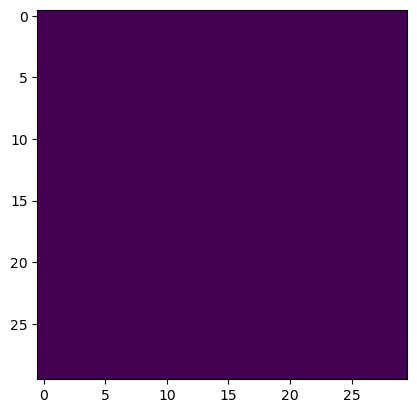

In [972]:
plt.imshow(source[:,:,11])

In [816]:
Matrix_plus = KK + (alpha**2)*(dt/2)*MM
Matrix_minus = KK - (alpha**2)*(dt/2)*MM

In [925]:
pkt = np.zeros((N,N))
for k in range(0,N):
    for l in range(0,N):
        Q[k + N*l,0] = 122*np.exp((-(x[k]-L/2)**2 - (y[l]-L/2)**2)/0.01)
        pkt[k,l] = Q[k + N*l,0]

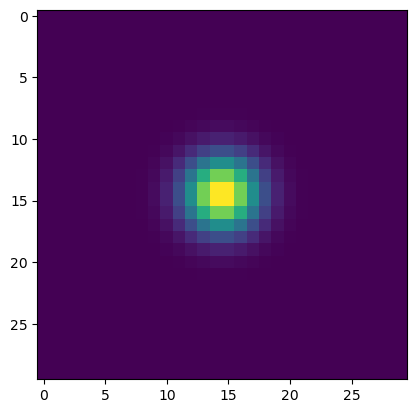

In [964]:
plt.imshow(pkt)

In [1013]:
for n in range(0, T-1):
    rp = (dt/2)*(F_mtrx[:,n]+F_mtrx[:,n+1]) + Matrix_minus.dot(Q[:,n])
    Q[:,n+1] = np.linalg.solve(Matrix_plus, rp)

In [1014]:
Term = np.zeros((N,N,T))

In [1015]:
for n in range(0, T):
    for k in range(0, N):
        for l in range(0, N):
            Term[k,l,n] = Q[k + N*l,n]


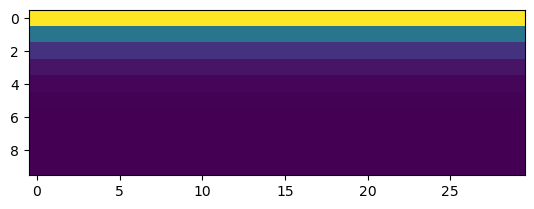

In [995]:
plt.imshow(Term[20:,:,300])

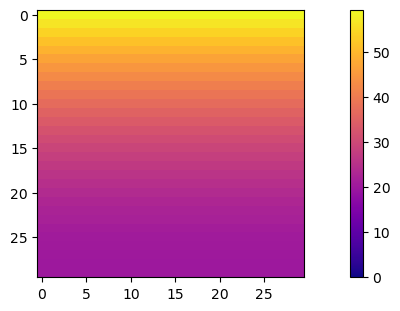

In [1016]:
fig, axs = plt.subplots(figsize=(10,3), constrained_layout=True)
p1 = axs.imshow(Term[:,:,-1], cmap='plasma', aspect='equal', vmin=np.min(Term), vmax=np.max(Term))
fig.colorbar(p1)

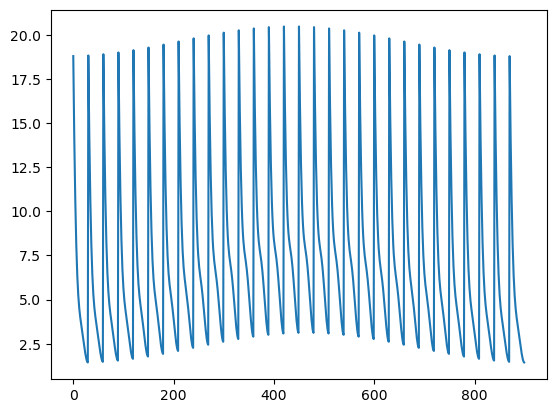

In [930]:
plt.plot(Q[:,-1])

In [900]:
u = np.zeros((N, N, T))
for n in range(0, T):
    for i in range(0, N):
        for j in range(0, N):
            u[:,:,n] = u[:,:,n] + Q[i+N*j,n] * Set_phi[i+N*j]

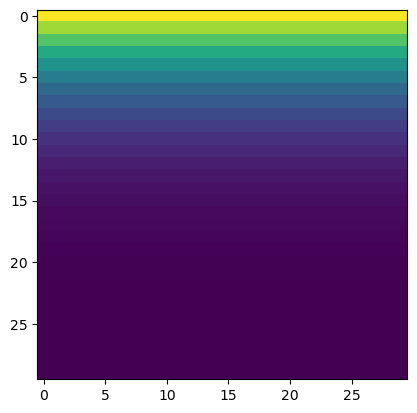

In [901]:
plt.imshow(u[:,:,-1])